In [8]:
import utils
import plotting
import postprocessing
import corrections
from collections import OrderedDict

from utils import CUT_MAX_VAL, ShapeVar
from hh_vars import (
    years,
    data_key,
    qcd_key,
    bg_keys,
    samples,
    nonres_sig_keys,
    nonres_samples,
    txbb_wps,
    jec_shifts,
    jmsr_shifts,
)
from postprocessing import nonres_shape_vars, Region

import numpy as np
import pandas as pd
import pickle

# from pandas.errors import SettingWithCopyWarning
from hist import Hist

import os
from copy import deepcopy
from inspect import cleandoc
import warnings

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import vector

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

# ignore these because they don't seem to apply
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
MAIN_DIR = "../../../"
samples_dir = f"{MAIN_DIR}/../data/skimmer/anava/Test"
samples_dir = "/home/users/annava/projects/HHbbVV/src/HHbbVV/VBF_binder/data2"
# samples_dir = "/eos/uscms/store/user/anava/bbVV/skimmer/Test/"
year = "2017"

date = "23Sep2"
plot_dir = f"../../../plots/PostProcessing/{date}/"
plot_dir = "/home/users/annava/projects/HHbbVV/src/HHbbVV/VBF_binder/vbf_tests_output"
templates_dir = f"templates/{date}"
_ = os.system(f"mkdir -p {plot_dir}")
_ = os.system(f"mkdir -p {plot_dir}/cutflows/")
_ = os.system(f"mkdir -p {plot_dir}/ControlPlots/{year}/")
_ = os.system(f"mkdir -p {plot_dir}/templates/")
# _ = os.system(f"mkdir -p {plot_dir}/templates/wshifts")
# _ = os.system(f"mkdir -p {plot_dir}/templates/jshifts")
# _ = os.system(f"mkdir -p {templates_dir}")
print(plot_dir)

/home/users/annava/projects/HHbbVV/src/HHbbVV/VBF_binder/vbf_tests_output


Load samples

In [11]:
filters = postprocessing.new_filters
systematics = {year: {}}

# save cutflow as pandas table
cutflow = pd.DataFrame(index=list(samples.keys()) + list(nonres_samples.keys()))

# utils.remove_empty_parquets(samples_dir, year)
events_dict = utils.load_samples(samples_dir, nonres_samples, year, filters)
events_dict |= utils.load_samples(samples_dir, samples, year, filters)

utils.add_to_cutflow(events_dict, "Preselection", "weight", cutflow)

cutflow

Loaded GluGluToHHTobbVV_node_cHHH1                       : 163771 entries
Loaded GluGluToHHTobbVV_node_cHHH2p45                    : 311922 entries
Loaded GluGluToHHTobbVV_node_cHHH5                       : 45263 entries
Loaded GluGluToHHTobbVV_node_cHHH0                       : 120297 entries
Loaded VBF_HHTobbVV_CV_1_C2V_1_C3_1                      : 18031 entries
Loaded VBF_HHTobbVV_CV_1_C2V_0_C3_1                      : 526914 entries
Loaded VBF_HHTobbVV_CV_1_5_C2V_1_C3_1                    : 294062 entries
Loaded VBF_HHTobbVV_CV_1_C2V_1_C3_2                      : 20704 entries
Loaded VBF_HHTobbVV_CV_1_C2V_2_C3_1                      : 903859 entries
Loaded VBF_HHTobbVV_CV_1_C2V_1_C3_0                      : 18339 entries
Loaded VBF_HHTobbVV_CV_0_5_C2V_1_C3_1                    : 743726 entries
Loaded QCD_HT300to500                                    : 14 entries
Loaded QCD_HT500to700                                    : 16431 entries
Loaded QCD_HT1000to1500                        

,Preselection
QCD,2.910046e+13
TT,3.363292e+15
ST,3.953645e+12
V+Jets,4.585888e+11
Diboson,4.063831e+09
ggFHbb,5.548390e+07
VBFHbb,1.504368e+09
ZHbb,3.777704e+08
WHbb,4.425087e+08
ggZHbb,1.789535e+06


Scale factors and bb VV assignment

In [12]:
postprocessing.apply_weights(events_dict, year, cutflow)
bb_masks = postprocessing.bb_VV_assignment(events_dict)
# events_dict[sig_key] = postprocessing.postprocess_lpsfs(events_dict[sig_key])
cutflow



QCD_SCALE_FACTOR = 0.8371779611163435


,Preselection,TriggerEffs,QCD SF
QCD,2.910046e+13,1.190289e+06,9.964841e+05
TT,3.363292e+15,1.005813e+05,1.005813e+05
ST,3.953645e+12,7.260218e+03,7.260218e+03
V+Jets,4.585888e+11,3.864097e+04,3.864097e+04
Diboson,4.063831e+09,6.181264e+02,6.181264e+02
ggFHbb,5.548390e+07,2.367524e+02,2.367524e+02
VBFHbb,1.504368e+09,6.788173e+01,6.788173e+01
ZHbb,3.777704e+08,6.738379e+01,6.738379e+01
WHbb,4.425087e+08,1.135127e+02,1.135127e+02
ggZHbb,1.789535e+06,1.000476e+01,1.000476e+01


Control plots

[ShapeVar(var='DijetMass', label='$m^{jj}$ (GeV)', bins=[30, 600, 4000], reg=True, blind_window=None, significance_dir='right'), ShapeVar(var='bbFatJetPt', label='$p^{bb}_T$ (GeV)', bins=[30, 300, 1500], reg=True, blind_window=None, significance_dir='right'), ShapeVar(var='bbFatJetParticleNetMass', label='$m^{bb}_{reg}$ (GeV)', bins=[20, 50, 250], reg=True, blind_window=None, significance_dir='bin')]
None


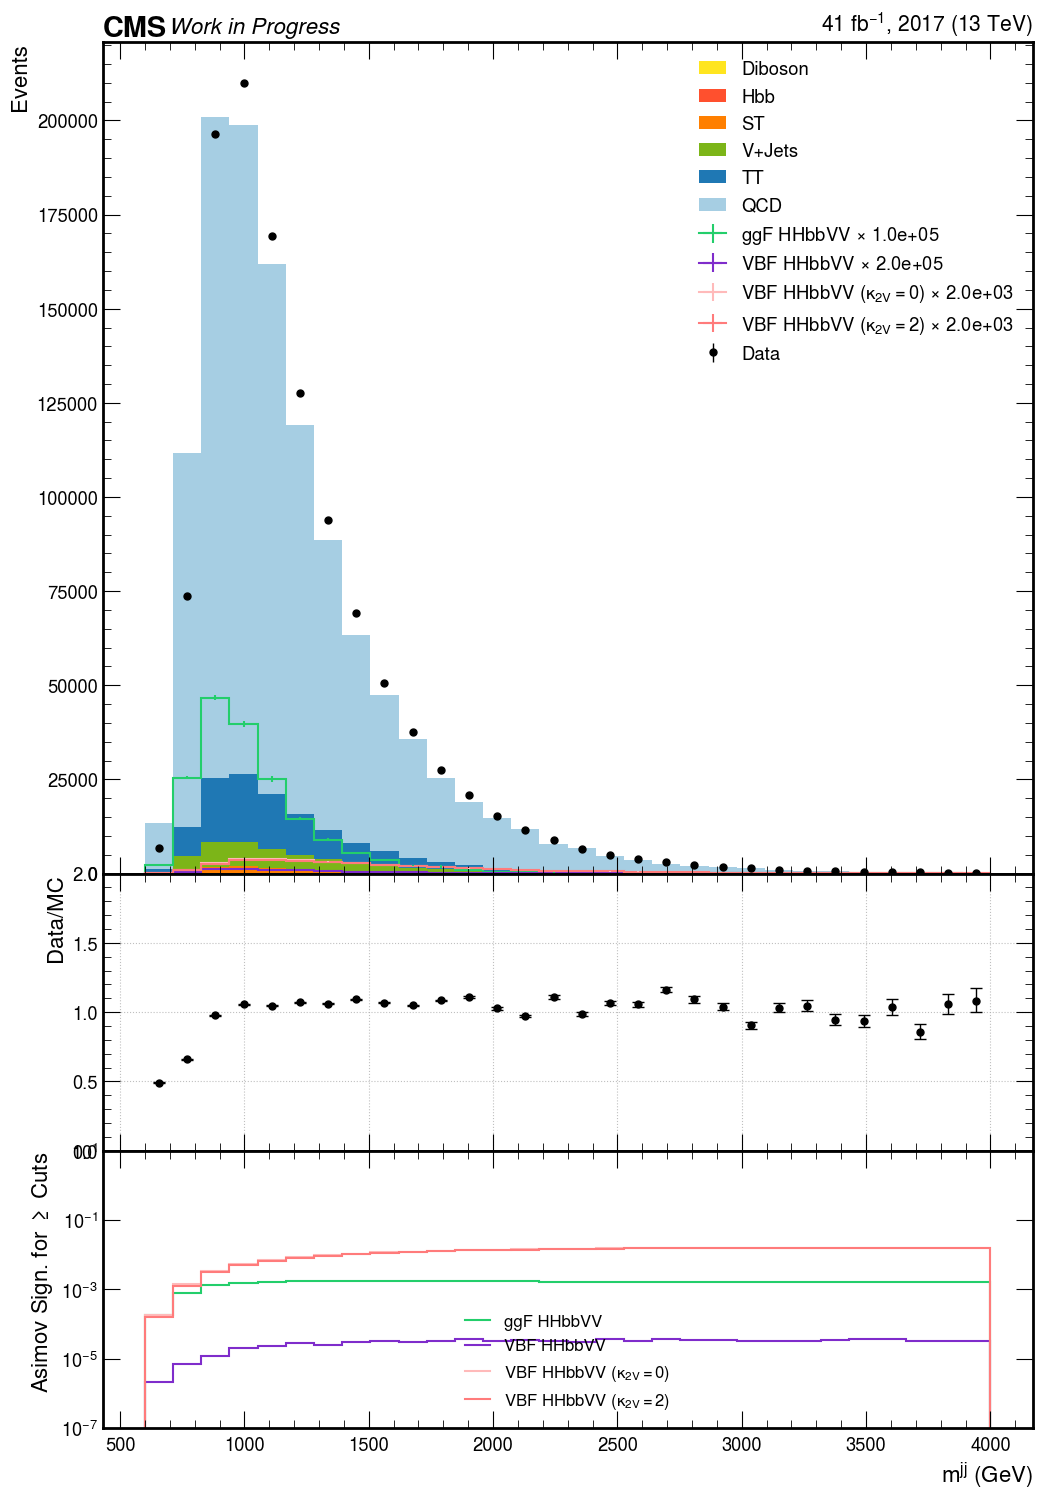

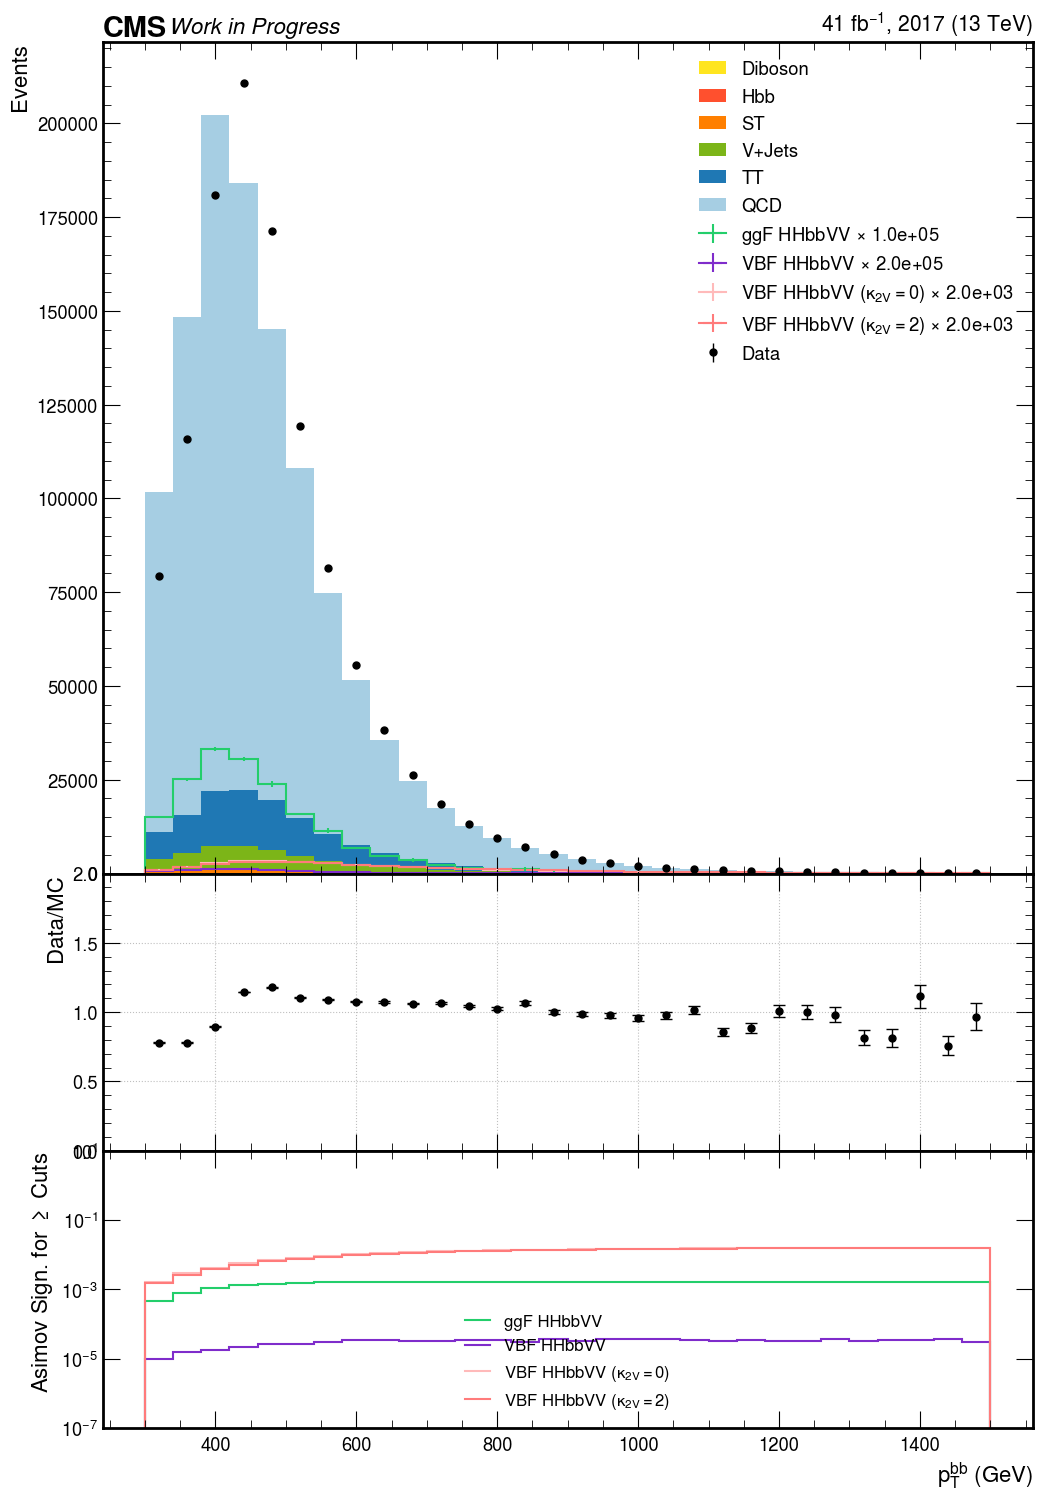

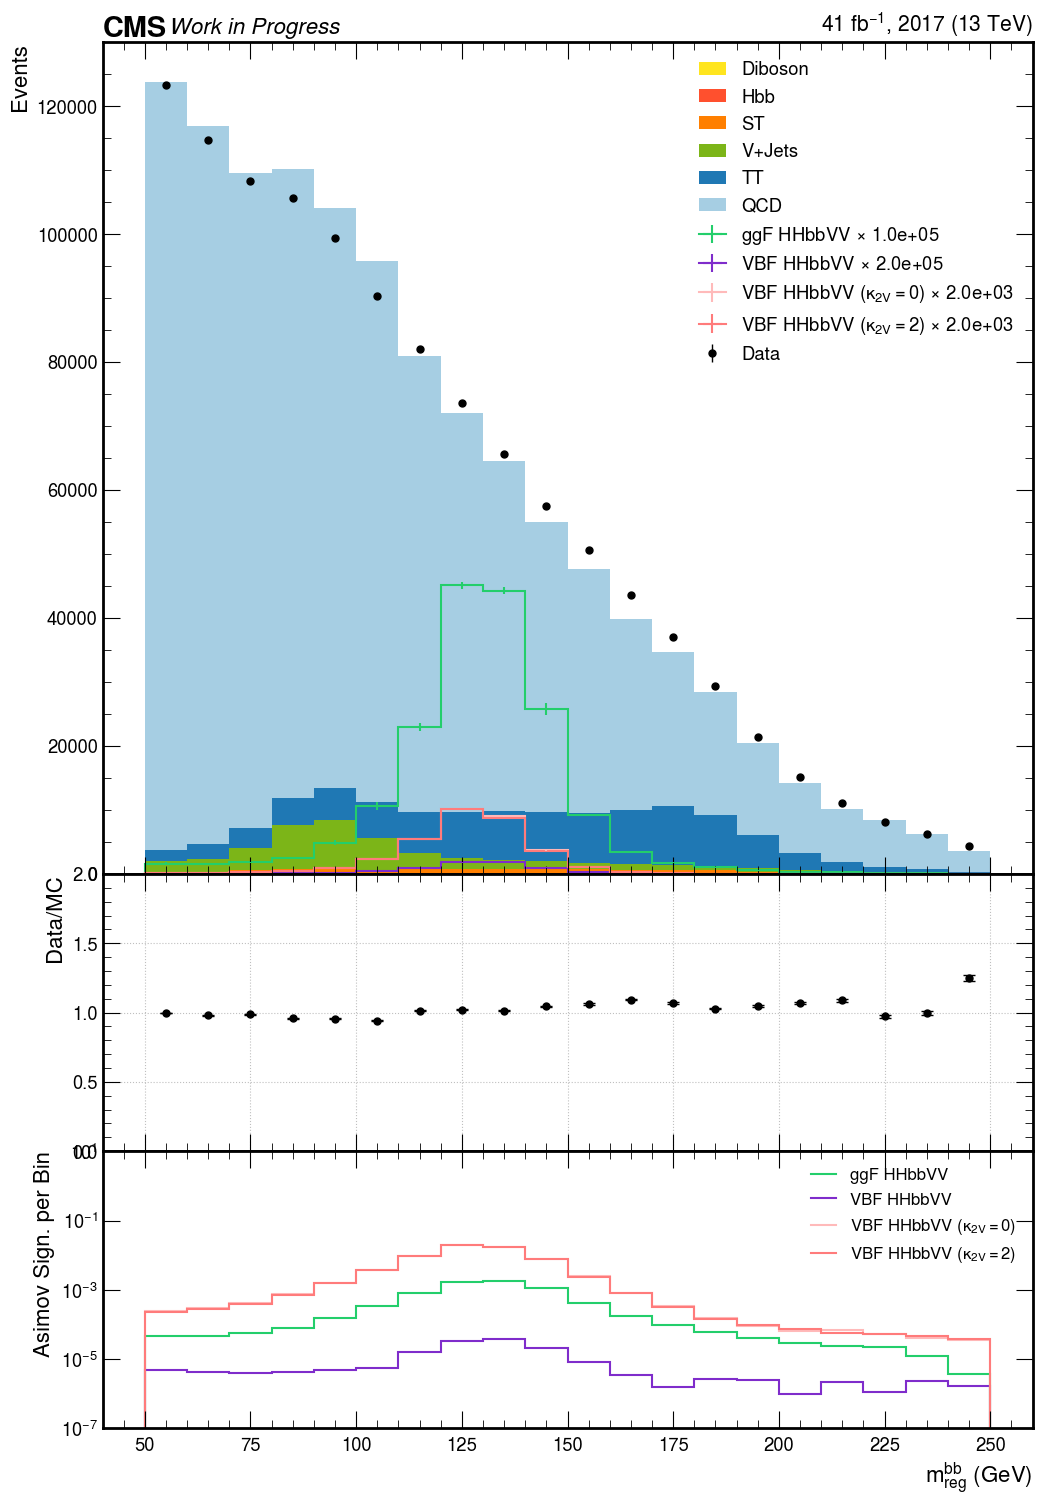

In [13]:
# {var: (bins, label)}
control_plot_vars = [
    # ShapeVar(var="MET_pt", label=r"$p^{miss}_T$ (GeV)", bins=[50, 0, 300]),
    # ShapeVar(var="DijetEta", label=r"$\eta^{jj}$", bins=[30, -8, 8]),
    # ShapeVar(var="DijetPt", label=r"$p_T^{jj}$ (GeV)", bins=[30, 0, 750]),
    ShapeVar(var="DijetMass", label=r"$m^{jj}$ (GeV)", bins=[30, 600, 4000]),
    # ShapeVar(var="bbFatJetEta", label=r"$\eta^{bb}$", bins=[30, -2.4, 2.4]),
    ShapeVar(
        var="bbFatJetPt", label=r"$p^{bb}_T$ (GeV)", bins=[30, 300, 1500], significance_dir="right"
    ),
    ShapeVar(
        var="bbFatJetParticleNetMass",
        label=r"$m^{bb}_{reg}$ (GeV)",
        bins=[20, 50, 250],
        significance_dir="bin",
    ),
    # ShapeVar(var="bbFatJetMsd", label=r"$m^{bb}_{msd}$ (GeV)", bins=[50, 0, 300]),
    # ShapeVar(var="bbFatJetParticleNetMD_Txbb", label=r"$T^{bb}_{Xbb}$", bins=[50, 0.8, 1]),
    # ShapeVar(var="VVFatJetEta", label=r"$\eta^{VV}$", bins=[30, -2.4, 2.4]),
    # ShapeVar(var="VVFatJetPt", label=r"$p^{VV}_T$ (GeV)", bins=[30, 300, 1500]),
    # ShapeVar(var="VVParticleNetMass", label=r"$m^{VV}_{reg}$ (GeV)", bins=[20, 50, 250]),
    # ShapeVar(var="VVFatJetMsd", label=r"$m^{VV}_{msd}$ (GeV)", bins=[40, 50, 250]),
    # ShapeVar(var="VVFatJetParticleNet_Th4q", label=r"Prob($H \to 4q$) vs Prob(QCD) (Non-MD)", bins=[50, 0, 1]),
    # ShapeVar(var="VVFatJetParTMD_THWW4q", label=r"Prob($H \to VV \to 4q$) vs Prob(QCD) (Mass-Decorrelated)", bins=[50, 0, 1]),
    # ShapeVar(var="VVFatJetParTMD_probT", label=r"Prob(Top) (Mass-Decorrelated)", bins=[50, 0, 1]),
    # ShapeVar(var="VVFatJetParTMD_THWWvsT", label=r"$T^{VV}_{HWW}$", bins=[50, 0, 1]),
    # ShapeVar(var="bbFatJetPtOverDijetPt", label=r"$p^{bb}_T / p_T^{jj}$", bins=[50, 0, 40]),
    # ShapeVar(var="VVFatJetPtOverDijetPt", label=r"$p^{VV}_T / p_T^{jj}$", bins=[50, 0, 40]),
    # ShapeVar(var="VVFatJetPtOverbbFatJetPt", label=r"$p^{VV}_T / p^{bb}_T$", bins=[50, 0.4, 2.0]),
    # ShapeVar(var="nGoodMuons", label=r"# of Muons", bins=[3, 0, 3]),
    # ShapeVar(var="nGoodElectrons", label=r"# of Electrons", bins=[3, 0, 3]),
    # ShapeVar(var="nGoodJets", label=r"# of AK4 B-Jets", bins=[5, 0, 5]),
    # ShapeVar(var="BDTScore", label=r"BDT Score", bins=[50, 0, 1]),
]

hists = postprocessing.control_plots(
    events_dict,
    bb_masks,
    ["HHbbVV", "VBFHHbbVV", "qqHH_CV_1_C2V_0_kl_1_HHbbVV", "qqHH_CV_1_C2V_2_kl_1_HHbbVV"],
    control_plot_vars,
    f"{plot_dir}/ControlPlots/{year}/",
    year,
    bg_keys=bg_keys,
    # bg_keys=["QCD", "TT", "ST", "V+Jets", "Hbb"],
    sig_scale_dict={
        "HHbbVV": 1e5,
        "VBFHHbbVV": 2e5,
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 2e3,
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV": 2e3,
    },
    plot_significance=True,
    show=True,
    log=False,
)

In [ ]:
# add variables to the dict that are necessary
for df in events_dict.values():
    ptlabel = "_JES_up"
    mlabel = "_JMS_down"
    bb_mask = (
                df[("ak8FatJetParticleNetMD_Txbb", 0)]
                > df[("ak8FatJetParticleNetMD_Txbb", 1)]
            )
    print(df[f"ak8FatJetPt{ptlabel}"])
    print(df[f"ak8FatJetPt{ptlabel}"][0])
    bbJet = vector.array(
        {
            "pt": np.where(bb_mask, df[f"ak8FatJetPt{ptlabel}"][0], df[f"ak8FatJetPt{ptlabel}"][1]),
            "phi": np.where(bb_mask, df["ak8FatJetPhi"][0], df["ak8FatJetPhi"][1]),
            "eta": np.where(bb_mask, df["ak8FatJetEta"][0], df["ak8FatJetEta"][1]),
            "M": np.where(bb_mask, df[f"ak8FatJetParticleNetMass{mlabel}"][0], df[f"ak8FatJetParticleNetMass{mlabel}"][1]),
        }
    )

    VVJet = vector.array(
        {
            "pt": np.where(~bb_mask, df[f"ak8FatJetPt{ptlabel}"][0], df[f"ak8FatJetPt{ptlabel}"][1]),
            "phi": np.where(~bb_mask, df["ak8FatJetPhi"][0], df["ak8FatJetPhi"][1]),
            "eta": np.where(~bb_mask, df["ak8FatJetEta"][0], df["ak8FatJetEta"][1]),
            "M": np.where(~bb_mask, df[f"ak8FatJetParticleNetMass{mlabel}"][0], df[f"ak8FatJetParticleNetMass{mlabel}"][1]),
        }
    )


    vbf1 = vector.array(
                {
                    "pt": df[('VBFJetPt', 0)],
                    "phi": df[('VBFJetPhi', 0)],
                    "eta": df[('VBFJetEta', 0)],
                    "M": df[('VBFJetMass', 0)],
                }
            )

    vbf2 = vector.array(
                {
                    "pt": df[('VBFJetPt', 1)],
                    "phi": df[('VBFJetPhi', 1)],
                    "eta": df[('VBFJetEta', 1)],
                    "M": df[('VBFJetMass', 1)],
                }
            )

    jj = vbf1 + vbf2

    mass_jj_cut_sorted_pt = jj.mass > 500
    eta_jj_cut_sorted_pt = np.abs(vbf1.eta - vbf2.eta) > 4.0

    # Adapted from HIG-20-005 ggF_Killer 6.2.2
    # https://coffeateam.github.io/coffea/api/coffea.nanoevents.methods.vector.PtEtaPhiMLorentzVector.html
    # https://coffeateam.github.io/coffea/api/coffea.nanoevents.methods.vector.LorentzVector.html
    # Adding variables defined in HIG-20-005 that show strong differentiation for VBF signal events and background

    # seperation between both ak8 higgs jets
    df[f"vbf_dR_HH"] = VVJet.deltaR(bbJet)
    df[f"vbf_dR_j0_HVV"] = vbf1.deltaR(VVJet)
    df[f"vbf_dR_j1_HVV"] = vbf2.deltaR(VVJet)
    df[f"vbf_dR_j0_Hbb"] = vbf1.deltaR(bbJet)
    df[f"vbf_dR_j1_Hbb"] = vbf2.deltaR(bbJet)
    df[f"vbf_dR_jj"] = vbf1.deltaR(vbf2)
    df[f"vbf_Mass_jj"] = jj.M
    df[f"vbf_dEta_jj"] = np.abs(vbf1.eta - vbf2.eta)

    # Subleading VBF-jet cos(θ) in the HH+2j center of mass frame:
    # https://github.com/scikit-hep/vector/blob/main/src/vector/_methods.py#L916
    system_4vec = vbf1 + vbf2 + VVJet + bbJet
    j1_CMF = vbf1.boostCM_of_p4(system_4vec)

    # Leading VBF-jet cos(θ) in the HH+2j center of mass frame:
    thetab1 = 2 * np.arctan(np.exp(-j1_CMF.eta))
    thetab1 = np.cos(thetab1)  # 12
    df[f"vbf_cos_j1"] = np.abs(thetab1)

    # Subleading VBF-jet cos(θ) in the HH+2j center of mass frame:
    j2_CMF = vbf2.boostCM_of_p4(system_4vec)
    thetab2 = 2 * np.arctan(np.exp(-j2_CMF.eta))
    thetab2 = np.cos(thetab2)
    df[f"vbf_cos_j2"] = np.abs(thetab2)

    # H1-centrality * H2-centrality:
    delta_eta = vbf1.eta - vbf2.eta
    avg_eta = (vbf1.eta + vbf2.eta) / 2
    prod_centrality = np.exp(
        -np.power((VVJet.eta - avg_eta) / delta_eta, 2)
        - np.power((bbJet.eta - avg_eta) / delta_eta, 2)
    )
    df[f"vbf_prod_centrality"] = prod_centrality

Templates

In [14]:
# add actual cuts here
selection_regions = {
    "pass": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [0.985, CUT_MAX_VAL],
            "nGoodVBFJets": [2, 40],
            "vbf_Mass_jj": [500, 10000],
            "vbf_dEta_jj": [4, 10000],
            "VVFatJetParticleNet_Th4q": [0.9, 1],
        },
        label="Pass",
    ),
    "fail": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [-CUT_MAX_VAL, 0.985],
            "nGoodVBFJets": [2, 40],
            "vbf_Mass_jj": [500, 10000],
            "vbf_dEta_jj": [4, 10000],
            "VVFatJetParticleNet_Th4q": [0.9, 1],
        },
        label="Fail",
    ),
}



# variable to plot
shape_vars = [
    postprocessing.ShapeVar(
        "bbFatJetParticleNetMass",
        r"$m^{bb}_\mathrm{Reg}$ (GeV)",
        [20, 50, 250],
        reg=True,
        blind_window=[100, 150],
    ),
]


t = postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    nonres_sig_keys,
    selection_regions,
    shape_vars,
    systematics,
    bg_keys=bg_keys,
    plot_sig_keys=[
        "HHbbVV",
        "VBFHHbbVV",
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV",
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV",
    ],
    sig_scale_dict={
        "HHbbVV": 1e4,
        "VBFHHbbVV": 1e5,
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 2e2,
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV": 2e2,
    },
    plot_dir=f"{plot_dir}/templates",
    prev_cutflow=cutflow,
    weight_shifts={},
    jshift="",
    plot_shifts=False,
    lpsfs=False,#1.23.5
    show=True,
)
cutflow

pass


TypeError: '>=' not supported between instances of 'NoneType' and 'int'

Here we extracted the data used in datacard (get_templates() prints out the cutflow.)

In [15]:
# variable to plot
shape_vars = [
    postprocessing.ShapeVar(
        "bbFatJetParticleNetMass",
        r"$m^{bb}_\mathrm{Reg}$ (GeV)",
        [20, 50, 250],
        reg=True,
        blind_window=[100, 150],
    ),
]
# A


# first we will do 0 to 115 mass cut pass and fail region. then we do 145 to 100000 pass and fail. the sums give (C,D)
# then we do one of 115 to 145 pass and fail (A,B)and we record each of the homies.
selection_regions_control1 = {
    "pass": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [0.985, CUT_MAX_VAL],
            "nGoodVBFJets": [2, 40],
            "vbf_Mass_jj": [400, 10000],
            "vbf_dEta_jj": [3, 10000],
            "VVFatJetParticleNet_Th4q": [0.9, 1],
            "bbFatJetParticleNetMass": [145, 100000],
        },
        label="Pass",
    ),
    "fail": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [-CUT_MAX_VAL, 0.985],
            "nGoodVBFJets": [2, 40],
            "vbf_Mass_jj": [400, 10000],
            "vbf_dEta_jj": [3, 10000],
            "VVFatJetParticleNet_Th4q": [0.9, 1],
            "bbFatJetParticleNetMass": [145, 100000],
        },
        label="Fail",
    ),
}

selection_regions_control2 = {
    "pass": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [0.985, CUT_MAX_VAL],
            "nGoodVBFJets": [2, 40],
            "vbf_Mass_jj": [400, 10000],
            "vbf_dEta_jj": [3, 10000],
            "VVFatJetParticleNet_Th4q": [0.9, 1],
            "bbFatJetParticleNetMass": [0, 115],
        },
        label="Pass",
    ),
    "fail": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [-CUT_MAX_VAL, 0.985],
            "nGoodVBFJets": [2, 40],
            "vbf_Mass_jj": [400, 10000],
            "vbf_dEta_jj": [3, 10000],
            "VVFatJetParticleNet_Th4q": [0.9, 1],
            "bbFatJetParticleNetMass": [0, 115],
        },
        label="Fail",
    ),
}

selection_regions_signal = {
    "pass": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [0.985, CUT_MAX_VAL],
            "nGoodVBFJets": [2, 40],
            "vbf_Mass_jj": [400, 10000],
            "vbf_dEta_jj": [3, 10000],
            "VVFatJetParticleNet_Th4q": [0.9, 1],
            "bbFatJetParticleNetMass": [115, 145],
        },
        label="Pass",
    ),
    "fail": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [-CUT_MAX_VAL, 0.985],
            "nGoodVBFJets": [2, 40],
            "vbf_Mass_jj": [400, 10000],
            "vbf_dEta_jj": [3, 10000],
            "VVFatJetParticleNet_Th4q": [0.9, 1],
            "bbFatJetParticleNetMass": [115, 145],
        },
        label="Fail",
    ),
}


t_signal = postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    nonres_sig_keys,
    selection_regions_signal,
    shape_vars,
    systematics,
    bg_keys=bg_keys,
    plot_sig_keys=[
        "HHbbVV",
        "VBFHHbbVV",
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV",
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV",
    ],
    sig_scale_dict={
        "HHbbVV": 1e4,
        "VBFHHbbVV": 1e5,
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 2e2,
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV": 2e2,
    },
    plot_dir=f"{plot_dir}/templates",
    prev_cutflow=cutflow,
    weight_shifts={},
    jshift="",
    plot_shifts=False,
    lpsfs=False,
    show=False,
)

t_control1 = postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    nonres_sig_keys,
    selection_regions_control1,
    shape_vars,
    systematics,
    bg_keys=bg_keys,
    plot_sig_keys=[
        "HHbbVV",
        "VBFHHbbVV",
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV",
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV",
    ],
    sig_scale_dict={
        "HHbbVV": 1e4,
        "VBFHHbbVV": 1e5,
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 2e2,
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV": 2e2,
    },
    plot_dir=f"{plot_dir}/templates",
    prev_cutflow=cutflow,
    weight_shifts={},
    jshift="",
    plot_shifts=False,
    lpsfs=False,
    show=False,
)


t_control2 = postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    nonres_sig_keys,
    selection_regions_control2,
    shape_vars,
    systematics,
    bg_keys=bg_keys,
    plot_sig_keys=[
        "HHbbVV",
        "VBFHHbbVV",
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV",
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV",
    ],
    sig_scale_dict={
        "HHbbVV": 1e4,
        "VBFHHbbVV": 1e5,
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 2e2,
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV": 2e2,
    },
    plot_dir=f"{plot_dir}/templates",
    prev_cutflow=cutflow,
    weight_shifts={},
    jshift="",
    plot_shifts=False,
    lpsfs=False,
    show=False,
)

pass
Trigger SF Unc.: 0.010



/home/users/annava/mambaforge/envs/cofenv/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


fail
Trigger SF Unc.: 0.003

pass
Trigger SF Unc.: 0.014

fail
Trigger SF Unc.: 0.003

pass
Trigger SF Unc.: 0.008

fail
Trigger SF Unc.: 0.003



In [ ]:
t

In [ ]:
categories = [
    "HHbbVV",
    "ggHH_kl_2p45_kt_1_HHbbVV",
    "ggHH_kl_5_kt_1_HHbbVV",
    "ggHH_kl_0_kt_1_HHbbVV",
    "VBFHHbbVV",
    "qqHH_CV_1_C2V_0_kl_1_HHbbVV",
    "qqHH_CV_1p5_C2V_1_kl_1_HHbbVV",
    "qqHH_CV_1_C2V_1_kl_2_HHbbVV",
    "qqHH_CV_1_C2V_2_kl_1_HHbbVV",
    "qqHH_CV_1_C2V_1_kl_0_HHbbVV",
    "qqHH_CV_0p5_C2V_1_kl_1_HHbbVV",
    "QCD",
    "TT",
    "ST",
    "V+Jets",
    "Diboson",
    "ggFHbb",
    "VBFHbb",
    "ZHbb",
    "WHbb",
    "ggZHbb",
    "ttHbb",
    "Data",
    "HHbbVV_txbb_down",
    "ggHH_kl_2p45_kt_1_HHbbVV_txbb_down",
    "ggHH_kl_5_kt_1_HHbbVV_txbb_down",
    "ggHH_kl_0_kt_1_HHbbVV_txbb_down",
    "VBFHHbbVV_txbb_down",
    "qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_down",
    "qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_down",
    "qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_down",
    "qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_down",
    "qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_down",
    "qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_txbb_down",
    "HHbbVV_txbb_up",
    "ggHH_kl_2p45_kt_1_HHbbVV_txbb_up",
    "ggHH_kl_5_kt_1_HHbbVV_txbb_up",
    "ggHH_kl_0_kt_1_HHbbVV_txbb_up",
    "VBFHHbbVV_txbb_up",
    "qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_up",
    "qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_up",
    "qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_up",
    "qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_up",
    "qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_up",
    "qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_txbb_up",
]
hhbbvv_index = categories.index("HHbbVV")
index = categories.index("Data")


# Assuming you have the Hist objects as hist_pass and hist_fail
hist_pass = t_signal["pass"]
hist_fail = t_signal["fail"]

hist_pass_values = hist_pass.values()
hist_fail_values = hist_fail.values()


hhbbvv_values_pass = hist_pass_values[index]
hhbbvv_values_fail = hist_fail_values[index]


print(type(hist_pass.values()))
# print(hist_pass.values())
print(dir(hist_pass))

total_events_pass = np.sum(hhbbvv_values_pass)
total_events_fail = np.sum(hhbbvv_values_fail)

print(f"Total number of 'HHbbVV' events in 'pass' histogram: {total_events_pass}")  # 0.023298
print(f"Total number of 'HHbbVV' events in 'fail' histogram: {total_events_fail}")  # 0.019126

In [ ]:
datasets_of_interest = [
    "VBFHHbbVV",
    "qqHH_CV_1_C2V_2_kl_1_HHbbVV",
    "qqHH_CV_1_C2V_0_kl_1_HHbbVV",
    "Data",
]
abcd_regions = {}
categories = [
    "HHbbVV",
    "ggHH_kl_2p45_kt_1_HHbbVV",
    "ggHH_kl_5_kt_1_HHbbVV",
    "ggHH_kl_0_kt_1_HHbbVV",
    "VBFHHbbVV",
    "qqHH_CV_1_C2V_0_kl_1_HHbbVV",
    "qqHH_CV_1p5_C2V_1_kl_1_HHbbVV",
    "qqHH_CV_1_C2V_1_kl_2_HHbbVV",
    "qqHH_CV_1_C2V_2_kl_1_HHbbVV",
    "qqHH_CV_1_C2V_1_kl_0_HHbbVV",
    "qqHH_CV_0p5_C2V_1_kl_1_HHbbVV",
    "QCD",
    "TT",
    "ST",
    "V+Jets",
    "Diboson",
    "ggFHbb",
    "VBFHbb",
    "ZHbb",
    "WHbb",
    "ggZHbb",
    "ttHbb",
    "Data",
    "HHbbVV_txbb_down",
    "ggHH_kl_2p45_kt_1_HHbbVV_txbb_down",
    "ggHH_kl_5_kt_1_HHbbVV_txbb_down",
    "ggHH_kl_0_kt_1_HHbbVV_txbb_down",
    "VBFHHbbVV_txbb_down",
    "qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_down",
    "qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_down",
    "qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_down",
    "qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_down",
    "qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_down",
    "qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_txbb_down",
    "HHbbVV_txbb_up",
    "ggHH_kl_2p45_kt_1_HHbbVV_txbb_up",
    "ggHH_kl_5_kt_1_HHbbVV_txbb_up",
    "ggHH_kl_0_kt_1_HHbbVV_txbb_up",
    "VBFHHbbVV_txbb_up",
    "qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_up",
    "qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_up",
    "qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_up",
    "qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_up",
    "qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_up",
    "qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_txbb_up",
]


# Loop through each dataset of interest
for dataset in datasets_of_interest:
    # Find the index in the categories list
    dataset_index = categories.index(dataset)

    # Initialize a sub-dictionary to hold the results for this dataset
    abcd_regions[dataset] = {}

    # Loop through 'pass' and 'fail'
    for pass_fail in ["pass", "fail"]:
        # Extract the number of events from each template (two for control since it is disjointed)
        hist_values_signal = t_signal[pass_fail].values()
        total_events_signal = np.sum(hist_values_signal[dataset_index])

        hist_values_control1 = t_control1[pass_fail].values()
        total_events_control1 = np.sum(hist_values_control1[dataset_index])

        hist_values_control2 = t_control2[pass_fail].values()
        total_events_control2 = np.sum(hist_values_control2[dataset_index])

        total_events_control = total_events_control1 + total_events_control2

        abcd_regions[dataset][f"signal_{pass_fail}"] = total_events_signal
        abcd_regions[dataset][f"control_{pass_fail}"] = total_events_control


abcd_regions

In [ ]:
def generate_datacard(data_values, signal_values):
    """Generate a datacard string based on the given values."""
    return f"""imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	   {data_values['signal_pass']} 	  {data_values['signal_fail']} 	 {data_values['control_pass']} 	 {data_values['control_fail']}
------------------------------
bin 	 chA 	 chA 	 chB 	 chB 	 chC 	 chC 	 chD 	 chD
process 	 sig	 bkg 	 sig	 bkg 	 sig	 bkg 	 sig	 bkg
process 	 0	 1	 0	 1	 0	 1	 0	 1
rate	 {signal_values['signal_pass']} 	 1 	 {signal_values['signal_fail']} 	 1 	 {signal_values['control_pass']} 	 1 	 {signal_values['control_fail']} 	 1
------------------------------
single_A    rateParam       chA     bkg      (@0*@1/@2)                    single_B,single_C,single_D
single_B    rateParam       chB     bkg     {data_values['signal_fail']}
single_C    rateParam       chC     bkg     {data_values['control_pass']}
single_D    rateParam       chD     bkg     {data_values['control_fail']}
norm rateParam * sig 1
single_lumi 	 lnN 	 1.2	 -  	 1.2	 -  	 1.2	 -  	 1.2	 -  
"""


# Extract Data values
data_values = abcd_regions["Data"]

# Loop through each signal and generate a datacard
for dataset in datasets_of_interest:
    if dataset == "Data":  # Skip 'Data'
        continue
    signal_values = abcd_regions[dataset]
    datacard_text = generate_datacard(data_values, signal_values)

    # Save to a text file
    filename = f"/home/users/annava/CMSSW_12_3_4/src/HiggsAnalysis/CombinedLimit/datacards/datacard_{dataset}.txt"
    with open(filename, "w") as f:
        f.write(datacard_text)

    print(f"Datacard for {dataset} has been saved as {filename}.")